### Carrega as bibliotecas necessárias para o projeto

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory


from google.colab import drive

import zipfile
import tarfile
import os
import shutil

from datetime import datetime

import cv2

from collections import defaultdict, Counter

import concurrent.futures

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cria objeto para download e organização das imagens do dataset

In [64]:
class Cria_Dataset:
  def __init__(self, caminho_do_projeto_no_google_drive, numero_de_classes):
    self.path_origem = caminho_do_projeto_no_google_drive
    self.compressed_folder = os.path.join(self.path_origem, 'Compressed')
    self.images_folder = os.path.join(self.path_origem, 'Images')
    self.temp_images_folder = os.path.join(self.path_origem, 'Images', 'Temp')
    self.num_classes = numero_de_classes


  def cria_estrutura_dir_imagens(self):
    '''
    Cria estrutura de diretório do tipo:

      Projeto
      |--- Images
      |---- class_1
      |---- class_2
      ...
      |---- class n
    '''

    # Verifica se os diretorios existem e cria apenas se não existirem
    for dir_num in range(self.num_classes):
      nome_dir_classe = 'class_' + str(dir_num + 1)
      dir_nome = os.path.join(self.images_folder, nome_dir_classe)
       # VErifica se os diretorios existem e cria apenas se não existirem
      if not os.path.exists(dir_nome):
        os.makedirs(dir_nome, exist_ok = True)
        print(f'O diretório {nome_dir_classe} foi criado')



  def move_imagens_temp_class(self):
    '''
      Move os arquivos de imagens
      de
        \Projeto\Images\Temp

      para
        \Projeto\Images\Class_1
        \Projeto\Images\Class_2
        ...
        \Projeto\Images\Class_42
    '''
    path_origem = self.temp_images_folder

    # Gera automaticamente o dicionário de prefixos para classes
    prefix_to_class = {f"{i:02}": f"class_{i}" for i in range(1, self.num_classes + 1)}

    # Executa função de criação da estrutura de pastas
    self.cria_estrutura_dir_imagens()

    for arquivo in os.listdir(path_origem):
      origem = os.path.join(path_origem, arquivo)
      # Verifica se é um arquivo (ignorar diretórios)
      if not os.path.isfile(origem):
        continue
      # Identifica a classe baseada no prefixo
      for prefixo, pasta in prefix_to_class.items():
        if arquivo.startswith(prefixo):
          destino = os.path.join(self.images_folder, pasta, arquivo)
          shutil.move(origem, destino)
    print('\nTodos os arquivos foram movidos com sucesso !')




  def faz_download(self, url_sem_arquivo, arquivo_para_baixar):
    '''
        Devem ser fornecidos:
          1. url_sem_arquivo: url sem o nome do arquivo a ser baixado.
             Exemplo:
                url_sem_arquivo = 'https://zenodo.org/record/10219797/files/'

          2. arquivo_para_baixar: lista com os nomes dos arquivos a serem baixados.
             Exemplo:
                arquivo_para_baixar = ['macroscopic0.zip', 'macroscopic1.tar.gz',
                                       'macroscopic2.tar.gz', 'macroscopic3.tar.gz',
                                       'macroscopic4.tar.gz']
    '''
    # Renomeia o diretório Compressed se já existir
    if os.path.exists(self.compressed_folder):
      timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
      novo_dir = self.compressed_folder + f"_backup_{timestamp}"
      shutil.move(self.compressed_folder, novo_dir)
      print(f"Diretório 'Compressed' existente foi renomeado para: {novo_dir}")

    # Criação dos diretórios \Compressed
    os.makedirs(self.compressed_folder, exist_ok=True)

    url_base = url_sem_arquivo
    files_to_download = arquivo_para_baixar

    # Faz o download dos arquivos
    for arquivo in files_to_download:
      url = url_base + arquivo
      destino = os.path.join(self.compressed_folder, arquivo)

      print(f'Baixando o arquivo {arquivo}...')
      !wget -O "{destino}" "{url}"
      print(f'Download do arquivo {arquivo} finalizado.\n')

    print('Todos os arquivos baixados com sucesso !')



  def verifica_arquivos_zip(self, arquivo_zip):
    '''
      Deve ser informado o nome do arquivo zip a ser descompactado.
      Exemplo:
        arquivo_zip = 'macroscopic0.zip'
    '''
    arquivo_zip_full_path = os.path.join(self.compressed_folder, arquivo_zip)

    # Verifica quantos arquivos estão no arquivo .zip
    with zipfile.ZipFile(arquivo_zip_full_path, 'r') as zip_ref:
      file_list = zip_ref.namelist()
      zip_num_files = len(file_list)
    return zip_num_files


  def verifica_arquivos_tar(self, arquivo_tar):
    '''
      Deve ser informado o nome do arquivo tar.gz a ser descompactado.
      Exemplo:
        arquivo_tar = 'macroscopic1.tar.gz'
    '''
    arquivo_tar_full_path = os.path.join(self.compressed_folder, arquivo_tar)

    # Verifica quantos arquivos estão no arquivo .tar.gz
    with tarfile.open(arquivo_tar_full_path, 'r:gz') as tar_ref:
        file_list = tar_ref.getnames()  # Lista os arquivos dentro do tar.gz
        tar_num_files = len(file_list)
    return tar_num_files



  def extrai_arquivos_zip(self, arquivo_zip):
    '''
      Deve ser informado o nome do arquivo zip a ser descompactado.
      Exemplo:
        arquivo_zip = 'macroscopic0.zip'
    '''
    arquivo_zip_full_path = os.path.join(self.compressed_folder, arquivo_zip)

    # Remove a pasta temporária
    if os.path.exists(self.temp_images_folder):
      shutil.rmtree(self.temp_images_folder)

    # Cria a pasta temporária novamente
    os.makedirs(self.temp_images_folder, exist_ok=True)

    # Extrai as imagens do arquivo zip para uma pasta temporária
    print('\nDescompactando as imagens')
    with zipfile.ZipFile(arquivo_zip_full_path, 'r') as zip_ref:
      zip_ref.extractall(self.temp_images_folder)

    # Conta o número de imagens extraídas
    arquivos_extraidos = os.listdir(self.temp_images_folder)
    num_arquivos_extraidos = len(arquivos_extraidos)

    # Verifica o número de imagens no arquivo zip
    zip_num_files = self.verifica_arquivos_zip(arquivo_zip)

    # Compara o número de imagens no arquivo zip com o número de imagens extraídas
    if num_arquivos_extraidos == zip_num_files:
      print(f'O arquivo {arquivo_zip} foi descompactado com sucesso !\n')

      # Move as imagens para o diretorio definitivo
      self.move_imagens_temp_class()
    else:
      print(f'\nO arquivo {arquivo_zip} não foi descompactado corretamente')



  def extrai_arquivos_tar(self, arquivo_tar):
    '''
      Deve ser informado o nome do arquivo tar.gz a ser descompactado.
      Exemplo:
        arquivo_tar = 'macroscopic1.tar.gz'
    '''
    arquivo_tar_full_path = os.path.join(self.compressed_folder, arquivo_tar)

    # Remove a pasta temporária
    if os.path.exists(self.temp_images_folder):
      shutil.rmtree(self.temp_images_folder)

    # Cria a pasta temporária novamente
    os.makedirs(self.temp_images_folder, exist_ok=True)

    # Extrai as imagens do arquivo tar.gz para uma pasta temporária
    print('\nDescompactando as imagens')
    with tarfile.open(arquivo_tar_full_path, 'r:gz') as tar_ref:
        tar_ref.extractall(self.temp_images_folder)

    # Conta o número de imagens extraídas
    arquivos_extraidos = os.listdir(self.temp_images_folder)
    num_arquivos_extraidos = len(arquivos_extraidos)

    # Verifica o número de imagens no arquivo zip
    tar_num_files = self.verifica_arquivos_tar(arquivo_tar)

    # Compara o número de imagens no arquivo tar.gz com o número de imagens extraídas
    if num_arquivos_extraidos == tar_num_files:
      print(f'\nO arquivo {arquivo_tar} foi descompactado com sucesso !\n')

      # Apaga todos os arquivos que se iniciam por ._
      for arquivo in os.listdir(self.temp_images_folder):
        if arquivo.startswith('.'):
          file_path = os.path.join(self.temp_images_folder, arquivo)
          os.remove(file_path)

      # Move as imagens para o diretorio definitivo
      self.move_imagens_temp_class()
    else:
      print(f'\nO arquivo {arquivo_tar} não foi descompactado corretamente')


### Faz o download dos arquivos, cria a estrutura de pastas e organiza as imagens

In [63]:
caminho_do_projeto_no_google_drive = '/content/drive/MyDrive/USP/TCC/Application/Dataset'
url = 'https://zenodo.org/record/10219797/files/'
classes = 41
arquivos = ['macroscopic0.zip', 'macroscopic1.tar.gz', 'macroscopic2.tar.gz',
            'macroscopic3.tar.gz', 'macroscopic4.tar.gz']

dataset = Cria_Dataset(caminho_do_projeto_no_google_drive, classes)
dataset.faz_download(url, arquivos)
dataset = Cria_Dataset(caminho_do_projeto_no_google_drive, classes)
dataset.faz_download(url, arquivos)
dataset.extrai_arquivos_zip(arquivos[0])
for arquivos in arquivos[1:]:
  dataset.extrai_arquivos_tar(arquivos)

Baixando o arquivo macroscopic0.zip...
--2025-02-20 23:20:27--  https://zenodo.org/record/10219797/files/macroscopic0.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10219797/files/macroscopic0.zip [following]
--2025-02-20 23:20:28--  https://zenodo.org/records/10219797/files/macroscopic0.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1637314819 (1.5G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/USP/TCC/Application/Dataset/Compressed/macroscopic0.zip’

/content/drive/MyDr 100%[===================>]   1.52G  25.8MB/s    in 58s     

2025-02-20 23:21:26 (26.8 MB/s) - ‘/content/drive/MyDrive/USP/TCC/Application/Dataset/Compressed/macroscopic0.zip’ saved [1637314819/1637314819]

Download do arquivo macroscopic0.zip finali

### Carrega as imagens para uso

In [76]:
data_dir = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images'


raw_train_val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.1,  # 10% test
    subset="training",
    labels="inferred",
    label_mode="categorical",
    seed=44,
    batch_size=32,
    image_size=(224, 224)
)

test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.1,  # Same as above to ensure consistency
    subset="validation",  # This subset will be the test set
    labels="inferred",
    label_mode="categorical",
    seed=44,
    batch_size=32,
    image_size=(224, 224)
)

train_size = int(0.80 * len(raw_train_val_ds))  # 80% of the original dataset
train_ds = raw_train_val_ds.take(train_size)
val_ds = raw_train_val_ds.skip(train_size)  # Remaining 10%

class_names = raw_train_val_ds.class_names

Found 2942 files belonging to 41 classes.
Using 2648 files for training.
Found 2942 files belonging to 41 classes.
Using 294 files for validation.


In [77]:
print("Classes:", class_names)

Classes: ['class_1', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14', 'class_15', 'class_16', 'class_17', 'class_18', 'class_19', 'class_2', 'class_20', 'class_21', 'class_22', 'class_23', 'class_24', 'class_25', 'class_26', 'class_27', 'class_28', 'class_29', 'class_3', 'class_30', 'class_31', 'class_32', 'class_33', 'class_34', 'class_35', 'class_36', 'class_37', 'class_38', 'class_39', 'class_4', 'class_40', 'class_41', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


---

<br>

### Análise das imagens

#### Tamanho do dataset

In [67]:
images_folder = '/content/drive/MyDrive/USP/TCC/Application/Dataset/Images'

# Percorre uma estrutura de diretórios e conta o número de arquivos
num_arquivos = sum(len(files) for _, _, files in os.walk(images_folder))
print(f'O dataset contém {num_arquivos} imagens\n')

O dataset contém 2942 imagens



#### Tabela de distribuição de frequências

In [ ]:
arquivos_imagens = os.listdir(images_folder)

# Inicializa o dicionário com 'defaultdict'
qtd_imagens = defaultdict(int)

# Conta o número de ocorrências de um determinado prefixo
for imagem in arquivos_imagens:
    prefixo = imagem[:2]  # Extrai os 2 primeiros caracteres do nome do arquivo
    qtd_imagens[prefixo] += 1

freq = pd.DataFrame(list(qtd_imagens.items()), columns=['Id', 'Quantidade'])

freq

,Id,Quantidade
0,01,53
1,02,63
2,03,43
3,04,99
4,05,63
5,06,41
6,07,48
7,08,75
8,09,72
9,10,98


#### Gráfico com o quantitivo de imagens por tipo (Id)

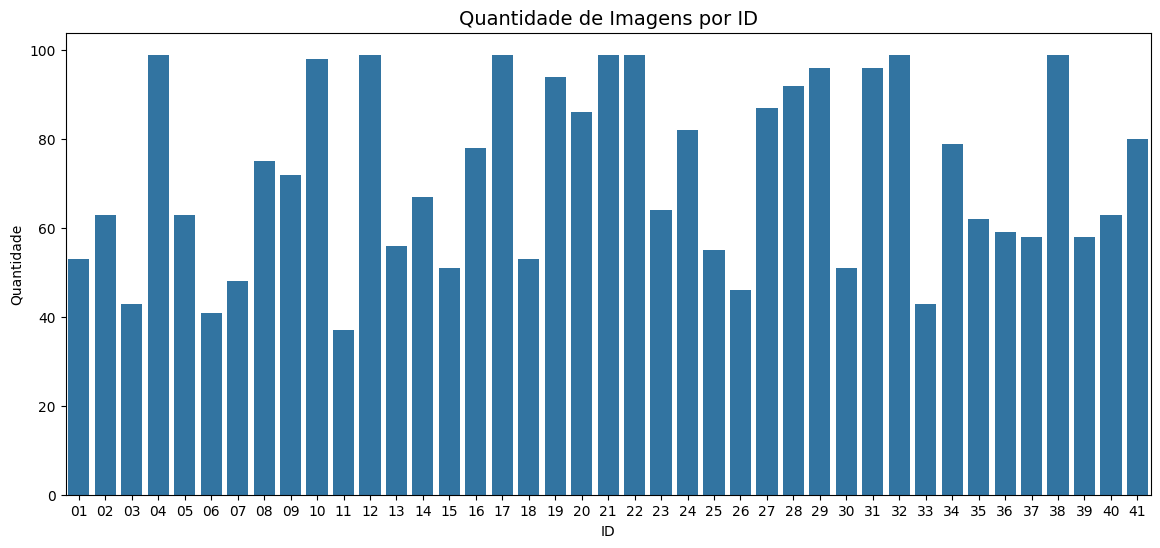

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(x='Id', y='Quantidade', data=freq)
plt.title('Quantidade de Imagens por ID', fontsize=14)
plt.xlabel('ID')
plt.ylabel('Quantidade')
plt.show()

In [ ]:
qtd_min = freq['Quantidade'].min()
qtd_max = freq['Quantidade'].max()

print(f'A quantidade mínima de imagens é {qtd_min}')
print(f'A quantidade máxima de imagens é {qtd_max}')

A quantidade mínima de imagens é 37
A quantidade máxima de imagens é 99


#### Visualização de imagens

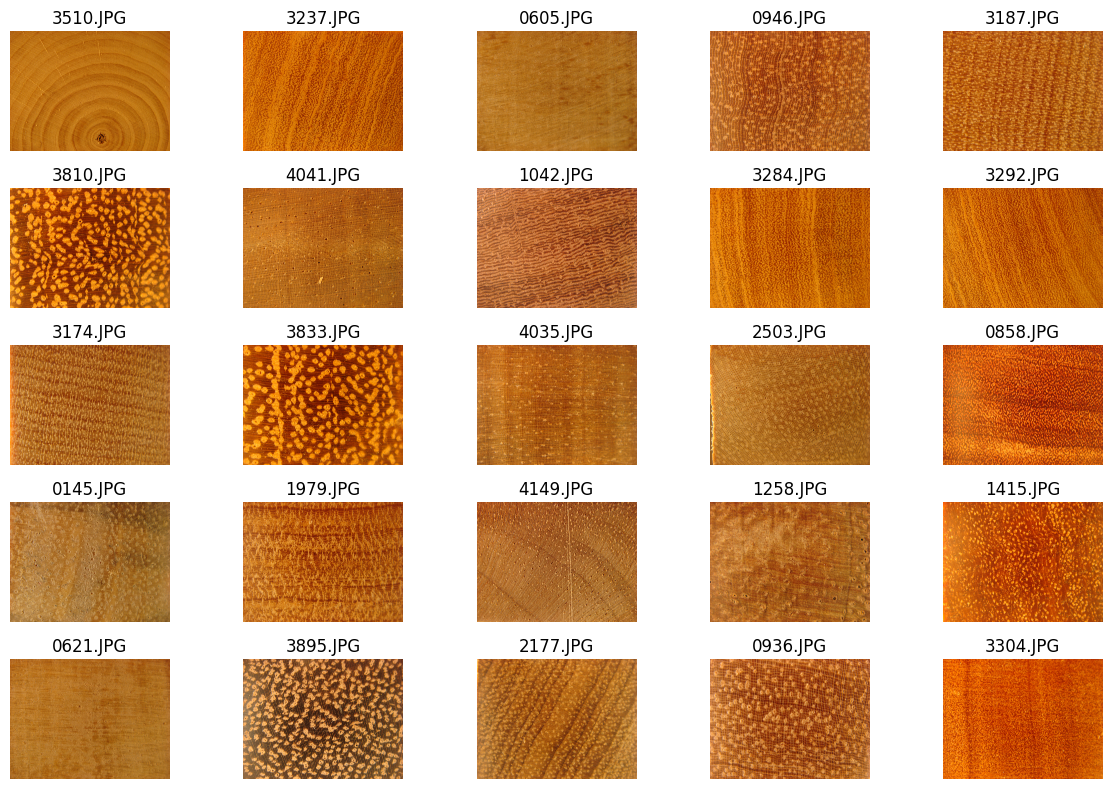

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(25):
    num_imagem = np.random.choice(arquivos_imagens)
    img = cv2.imread(os.path.join(images_folder, num_imagem))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for proper visualization

    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(num_imagem))

plt.tight_layout()
plt.show()

In [ ]:
arquivos_imagens = os.listdir(images_folder)

# Carrega a imagem e verifica a resolução
def resolucao_imagem(imagem):
    img_path = os.path.join(images_folder, imagem)
    img = cv2.imread(img_path)
    if img is not None:
        h, w, _ = img.shape
        return (w, h)
    return None

# Carregar imagens em paralelo
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    resolucao = list(filter(None, executor.map(resolucao_imagem, arquivos_imagens)))

contagem = Counter(resolucao)
print(f'Variações de resoluções encontradas: {len(contagem)}')
print(f'Resoluções mais comuns: {contagem.most_common(5)}')

Variações de resoluções encontradas 1
Resoluções mais comuns: [((3264, 2448), 2942)]


**Análise**  
- O dataset possui 2942 imagens referentes a 42 espécies de madeira.  
- As espécies possuem Ids numéricos que vão de 0 a 41.  
- Identificamos que a base de dados encontra-se desbalanceada com número de imagens por classe variando de 37 a 99.  
- Todas as imagens possuem a mesma resolução, isto é, 3264 x 2448 pixels.  